<a href="https://colab.research.google.com/github/Tsinta-Developers/AprendizajeReconocimientodePatrones/blob/main/Tarea3ARP_Guillermo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tarea 3. Regresión lineal en los parámetros con distintas funciones base. 23 de marzo.**

1. A partir de la función sin(2 pi x) generar 10 puntos de entrenamiento.
2. Hacer el ajuste a esos puntos por ML y determinar Wml, empleando la pseudo inversa de Moore – Penrose (ec. 3.15), variando el número de grados de libertad M = 1.. 10, para siguientes casos.
Funciones base monomios x**(M-1)
Funciones base Gaussianas
Funciones base Sigmoidales
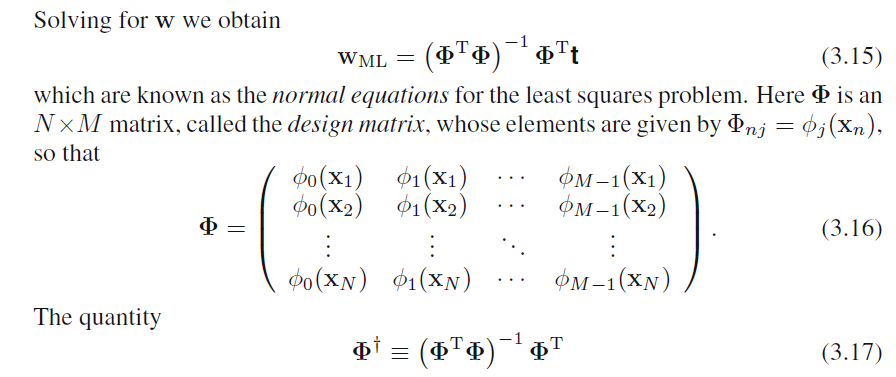
3. Generar 10 puntos de prueba.
4. Determinar cual es el mejor modelo para el conjunto de prueba midiendo el RSME.
5. Para cada tipo de función base hacer una gráfica del RSME con el conjunto de prueba, con M en el eje X y RSME en el eje Y.
6. Graficar en función de M, el RSME para el conjunto de prueba, y sólo poner el mejor ajuste de cada tipo de función base. En esta gráfica sólo aparezcan los 3 mejores ajustes.
7. Graficar finalmente el mejor ajuste donde aparezcan también los puntos del conjunto de entrenamiento, de prueba y la función sinusoidal.

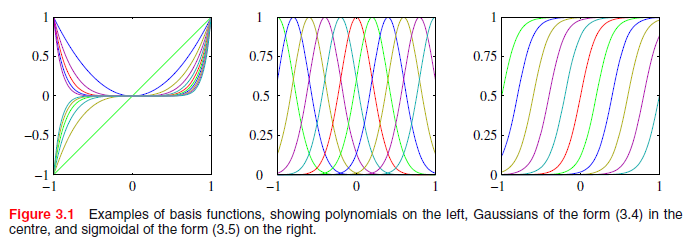

## Pre-requisitos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import colors, patches
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
try:
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
except ImportError:
    # use backports for sklearn 1.4
    from sklearn_backports import PolynomialFeatures
    from sklearn_backports import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import beta
from scipy import stats
%matplotlib inline

Ploteo

In [ ]:
def plot_data(x, t,h):
    plt.scatter(x, t, marker='o', c=h, s=20)

def plot_truth(x, y, label='Truth'):
    plt.plot(x, y, 'k--', label=label)

def plot_predictive(x, y, std, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.ravel()

    plt.plot(x, y, label=y_label)
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.1, label=std_label)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')

## Implementación

Función sinusoidal

In [ ]:
def func(x): return np.sin(2*np.pi*x)

Posterior 

In [ ]:
def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N

In [ ]:
def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)

In [ ]:
def polynomial_basis_function(x, power):
    return x ** power

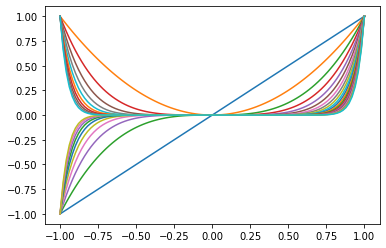

In [ ]:
X_P = np.linspace(-1,1,100)

for i in range(20):
  Y_P = polynomial_basis_function(X_P,i+1)
  plt.plot(X_P,Y_P)
  plt.grid()

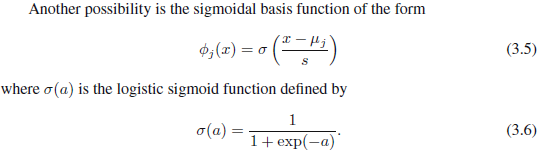

In [ ]:
def tan_basis_function(x,mu,sigma=.1):
  a = (x - mu)/ sigma
  s = 1 / (1+ np.exp(-a))
  return s

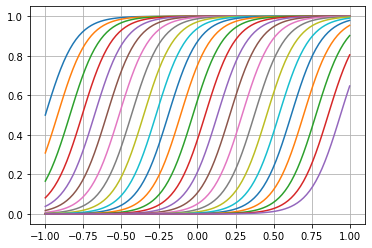

In [ ]:
X_P = np.linspace(-1,1,100)

for i in range(25):
  Y_P = tan_basis_function(X_P,np.mean(X_P[i*4]))
  plt.plot(X_P,Y_P)
  plt.grid()

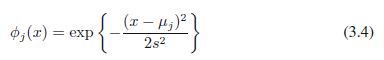

In [ ]:
def gaussian_basis_function(x, mu, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)

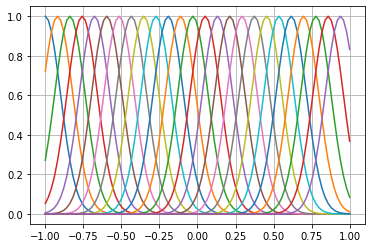

In [ ]:
X_P = np.linspace(-1,1,100)

for i in range(25):
  Y_P = gaussian_basis_function(X_P,np.mean(X_P[i*4]))
  plt.plot(X_P,Y_P)
  plt.grid()

In [ ]:
def g(X, noise_variance):
    '''Sinusoidal function plus noise'''
    return 0.5 + np.sin(2 * np.pi * X) + noise(X.shape, noise_variance)

In [ ]:
def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

In [ ]:
def posterior_predictive(Phi_test, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    y = Phi_test.dot(m_N)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = 1 / beta + np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    
    return y, y_var

In [ ]:
def RMS(x, t):
  E = 0.5*(np.sum((x-t)**2))
  Erms = np.sqrt((2*E)/len(x))
  return Erms

In [ ]:
# Genera los datos de entrenamiento a partir de la funcion base sinusoidal
n_samples = 20
X = np.linspace(0, 1, n_samples)[:, np.newaxis]
y_true = func(X)
y = func(X) + np.random.normal(0,0.1,size=(n_samples))[:, np.newaxis]
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.5)


In [ ]:
# 2. Hacer el ajuste a esos puntos por ML y determinar Wml, empleando la pseudo inversa de Moore – Penrose (ec. 3.15), variando el número de grados de libertad M = 1.. 10, para siguientes casos.
M = 9
Ms = range(M + 1)

wlM = expand(X_train, bf=polynomial_basis_function, bf_args=Ms[1:])
wlG = expand(X_train, bf=gaussian_basis_function, bf_args=Ms[1:])
wlS = expand(X_train, bf=tan_basis_function,bf_args=Ms[1:])
wlM, wlG, wlS

(array([[1.00000000e+00, 3.68421053e-01, 1.35734072e-01, 5.00072897e-02,
         1.84237383e-02, 6.78769306e-03, 2.50072902e-03, 9.21321219e-04,
         3.39434133e-04, 1.25054681e-04],
        [1.00000000e+00, 8.42105263e-01, 7.09141274e-01, 5.97171599e-01,
         5.02881347e-01, 4.23479029e-01, 3.56613919e-01, 3.00306458e-01,
         2.52889649e-01, 2.12959704e-01],
        [1.00000000e+00, 2.63157895e-01, 6.92520776e-02, 1.82242309e-02,
         4.79585025e-03, 1.26206585e-03, 3.32122593e-04, 8.74006824e-05,
         2.30001796e-05, 6.05267884e-06],
        [1.00000000e+00, 7.89473684e-01, 6.23268698e-01, 4.92054235e-01,
         3.88463870e-01, 3.06682003e-01, 2.42117370e-01, 1.91145292e-01,
         1.50904178e-01, 1.19134878e-01],
        [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.0

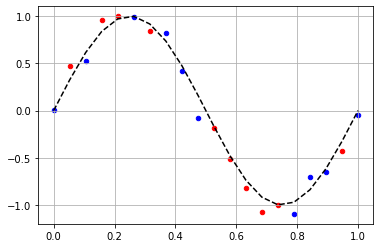

In [ ]:
plot_data(X_train, Y_train,'b')
plot_data(X_test,Y_test,'r')
plot_truth(X,y_true,"--k")
plt.grid()

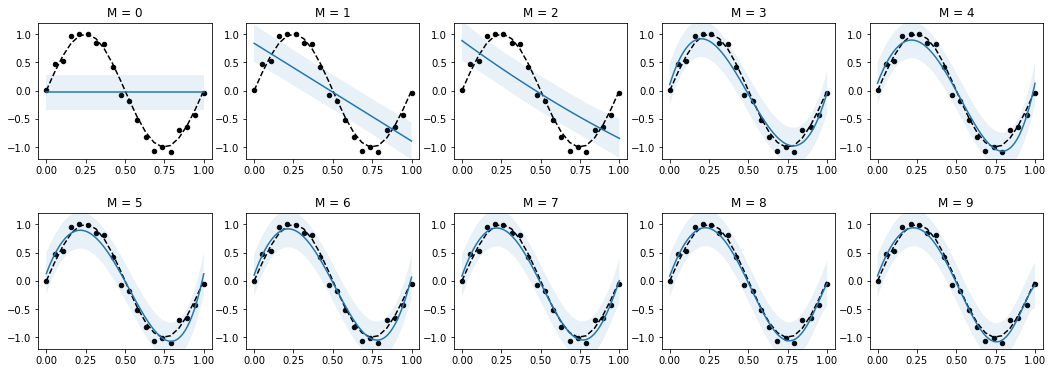

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplots_adjust(hspace=0.4)

X_t = np.linspace(0, 1, 100).reshape(-1, 1)
y_v = g(X_t, noise_variance=0)

beta = 1 / (0.3 ** 2)
alpha = 0.005

Phi1 = expand(X, bf=polynomial_basis_function, bf_args=range(1, M + 1))
Phi_test1 = expand(X_t, bf=polynomial_basis_function, bf_args=Ms[1:])

for d in Ms:
    up = d + 1
    Error = np.empty(10)
    m_N1, S_N1 = posterior(Phi1[:,:up], y, alpha, beta)
    y_train_P1, y_var1 = posterior_predictive(Phi_test1[:,:up], m_N1, S_N1, beta)
    Error[d] = RMS(y_true,y_var1)

    plt.subplot(2, 5, up)
    plot_data(X, y,'k')
    plot_truth(X, y_true, label=None)
    plot_predictive(X_t, y_train_P1, np.sqrt(y_var1), y_label=None, std_label=None, plot_xy_labels=False)
    plt.title(f'M = {d}')
    plt.ylim(-1.2, 1.2)

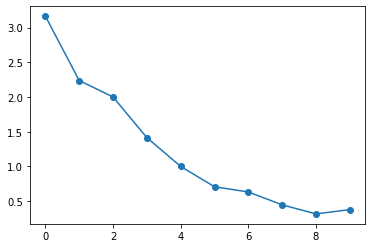

In [ ]:
plt.plot(np.arange(10),1/np.sqrt(Error),'-o')

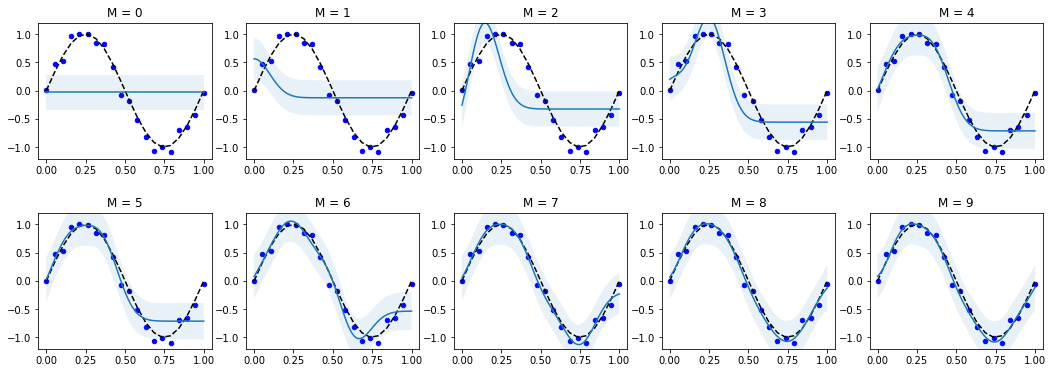

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplots_adjust(hspace=0.4)

X_t = np.linspace(0, 1, 100).reshape(-1, 1)
# y_true = g(X_test, noise_variance=0)

beta = 1 / (0.3 ** 2)
alpha = 0.005

Phi2 = expand(X, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 9))
Phi_test2 = expand(X_t, bf=gaussian_basis_function,bf_args=np.linspace(0, 1, 9))

for d in Ms:
    up = d + 1
    Error2 = np.empty(10)
    m_N2, S_N2 = posterior(Phi2[:,:up], y, alpha, beta)
    y_train_P2, y_var2 = posterior_predictive(Phi_test2[:,:up], m_N2, S_N2, beta)
    Error2[d] = RMS(y_true,y_var2)

    plt.subplot(2, 5, up)
    plot_data(X, y,'b')
    plot_truth(X, y_true, label=None)
    plot_predictive(X_t, y_train_P2, np.sqrt(y_var2), y_label=None, std_label=None, plot_xy_labels=False)
    plt.title(f'M = {d}')
    plt.ylim(-1.2, 1.2)

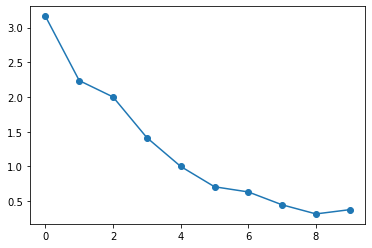

In [ ]:
plt.plot(np.arange(10),1/np.sqrt(Error2),'-o')

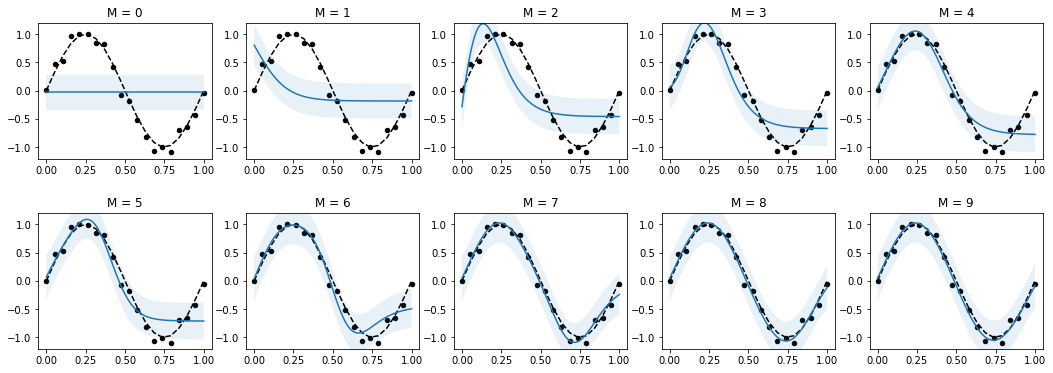

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplots_adjust(hspace=0.4)

X_t = np.linspace(0, 1, 100).reshape(-1, 1)
# y_true = g(X_test, noise_variance=0)

beta = 1 / (0.3 ** 2)
alpha = 0.005

Phi3 = expand(X, bf=tan_basis_function,bf_args=np.linspace(0, 1, 9))
Phi_test3 = expand(X_t, bf=tan_basis_function,bf_args=np.linspace(0, 1, 9))

for d in Ms:
    Error3 = np.empty(10)
    up = d + 1
    m_N3, S_N3 = posterior(Phi3[:,:up], y, alpha, beta)
    y_train_P3, y_var3 = posterior_predictive(Phi_test3[:,:up], m_N3, S_N3, beta)
    Error3[d] = RMS(y_true,y_var3)

    plt.subplot(2, 5, up)
    plot_data(X, y,'k')
    plot_truth(X, y_true, label=None)
    plot_predictive(X_t, y_train_P3, np.sqrt(y_var3), y_label=None, std_label=None, plot_xy_labels=False)
    plt.title(f'M = {d}')
    plt.ylim(-1.2, 1.2)

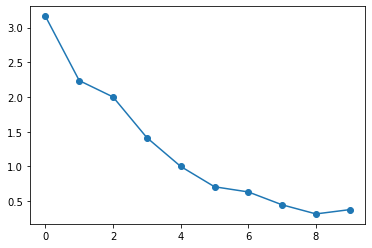

In [ ]:
plt.plot(np.arange(10),1/np.sqrt(Error3),'-o')

(0.0, 2.0)

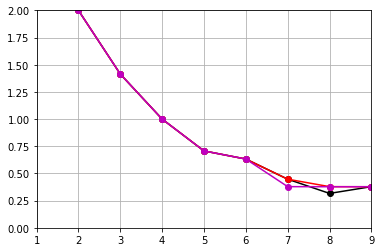

In [ ]:
plt.plot(np.arange(10),1/np.sqrt(Error),'-ok')
plt.plot(np.arange(10),1/np.sqrt(Error2),'-or')
plt.plot(np.arange(10),1/np.sqrt(Error3),'-om')
plt.grid()
plt.xlim(1,9)
plt.ylim(0,2)

In [ ]:
Min1 = np.sort(1/np.sqrt(Error))
min1 = np.where( 1/np.sqrt(Error)== Min1[0])[0]
Min2 = np.sort(1/np.sqrt(Error2))
min2 = np.where( 1/np.sqrt(Error2)== Min2[0])[0]
Min3 = np.sort(1/np.sqrt(Error3))
min3 = np.where( 1/np.sqrt(Error3)== Min3[0])[0]
min1, min2, min3

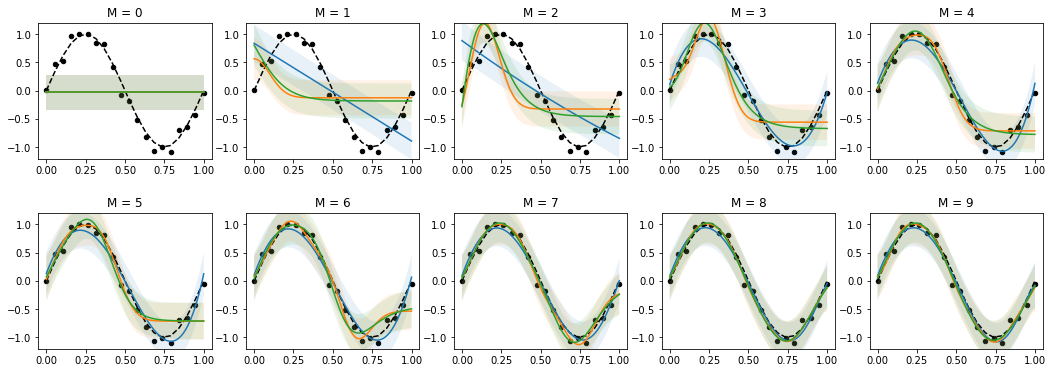

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplots_adjust(hspace=0.4)

for d in Ms:    


    up = d + 1
    Error1 = np.empty(10)
    Error2 = np.empty(10)
    Error3 = np.empty(10)
    m_N1, S_N1 = posterior(Phi1[:,:up], y, alpha, beta)
    y_train_P1, y_var1 = posterior_predictive(Phi_test1[:,:up], m_N1, S_N1, beta)
    Error1[d] = RMS(y_true,y_var1)
    m_N2, S_N2 = posterior(Phi2[:,:up], y, alpha, beta)
    y_train_P2, y_var2 = posterior_predictive(Phi_test2[:,:up], m_N2, S_N2, beta)
    Error2[d] = RMS(y_true,y_var2)
    m_N3, S_N3 = posterior(Phi3[:,:up], y, alpha, beta)
    y_train_P3, y_var3 = posterior_predictive(Phi_test3[:,:up], m_N3, S_N3, beta)
    Error3[d] = RMS(y_true,y_var3)

    plt.subplot(2, 5, up)
    plot_data(X, y,'k')
    plot_truth(X, y_true, label=None)
    plot_predictive(X_t, y_train_P1, np.sqrt(y_var1), y_label=None, std_label=None, plot_xy_labels=False)
    plot_predictive(X_t, y_train_P2, np.sqrt(y_var2), y_label=None, std_label=None, plot_xy_labels=False)
    plot_predictive(X_t, y_train_P3, np.sqrt(y_var3), y_label=None, std_label=None, plot_xy_labels=False)
    plt.title(f'M = {d}')
    plt.ylim(-1.2, 1.2)

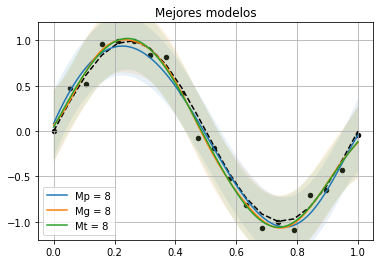

In [ ]:
    up = 9
    m_N1, S_N1 = posterior(Phi1[:,:min1[0]+1], y, alpha, beta)
    y_train_P1, y_var1 = posterior_predictive(Phi_test1[:,:min1[0]+1], m_N1, S_N1, beta)
    Error1[d] = RMS(y_true,y_var1)
    m_N2, S_N2 = posterior(Phi2[:,:min2[0]+1], y, alpha, beta)
    y_train_P2, y_var2 = posterior_predictive(Phi_test2[:,:min2[0]+1], m_N2, S_N2, beta)
    Error2[d] = RMS(y_true,y_var2)
    m_N3, S_N3 = posterior(Phi3[:,:min3[0]+1], y, alpha, beta)
    y_train_P3, y_var3 = posterior_predictive(Phi_test3[:,:min3[0]+1], m_N3, S_N3, beta)
    Error3[d] = RMS(y_true,y_var3)

    plot_data(X, y,'k')
    plot_truth(X, y_true, label=None)
    plot_predictive(X_t, y_train_P1, np.sqrt(y_var1), y_label=f'Mp = {min1[0]}', std_label=None, plot_xy_labels=False)
    plot_predictive(X_t, y_train_P2, np.sqrt(y_var2), y_label=f'Mg = {min2[0]}', std_label=None, plot_xy_labels=False)
    plot_predictive(X_t, y_train_P3, np.sqrt(y_var3), y_label=f'Mt = {min3[0]}', std_label=None, plot_xy_labels=False)
    plt.title('Mejores modelos')
    plt.legend(loc='lower left')
    plt.ylim(-1.2, 1.2)
    plt.grid()

In [ ]:
plErr1 = np.sort(1/np.sqrt(Error))
gErr2 = np.sort(1/np.sqrt(Error2))
tErr3 = np.sort(1/np.sqrt(Error3))
plErr1[0],gErr2[0],tErr3[0]


(0.31622776601683794, 0.3776576250739052, 0.3776576250739052)